In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation

In [2]:
def plot_generator_paper(sample, X, Z):
    
    fz = 15*1.25
    lw = 4
    siz = 100
    XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
    XTEXT = 0.25 # Text placement
    YTEXT = 0.3 # Text placement
    
    plt.rc('text', usetex=False)
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    #mpl.rcParams["font.serif"] = "STIX"
    plt.rc('font', family='serif', size=fz)
    matplotlib.rcParams['lines.linewidth'] = lw
    
    
    cmap="RdBu_r"
    fig, ax = plt.subplots(1,1, figsize=(15,6))
    cs0 = ax.pcolor(X, Z, sample, cmap=cmap, vmin=-1.0, vmax = 1.0)
    ax.set_title("Anomalous Vertical Velocity Field Detected By ELBO")
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel("CRMs", fontsize=fz*1.5)
    ax.xaxis.set_label_coords(0.54,-0.05)
    h = ax.set_ylabel("hPa", fontsize = fz*1.5)
    h.set_rotation(0)
    ax.yaxis.set_label_coords(-0.10,0.44)
    #y_ticks = np.arange(1350, 0, -350)
    #ax.set_yticklabels(y_ticks, fontsize=fz*1.33)
    ax.tick_params(axis='x', labelsize=fz*1.33)
    ax.tick_params(axis='y', labelsize=fz*1.33)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(cs0, cax=cax)
    cbar.set_label(label=r'$\left(\mathrm{m\ s^{-1}}\right)$', rotation="horizontal", fontsize=fz*1.5, labelpad=30, y = 0.65)
    plt.show()
    #plt.savefig("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/CI_Figure_Data/Anomaly.pdf")
    
#plot_generator(test[0,:,:])

In [3]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [4]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
lons = np.array(others.variables['lon'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [5]:
z_test_tsne_track = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/model_graphs/latent_space/3D_PCA_Latent_Space__31.npy")

Test_Images = np.load("/fast/gmooers/Preprocessed_Data/W_Variable/Trackable_Space_Time_W_Test.npy")
Max_Scalar = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Max_Scalar.npy")
Min_Scalar = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Min_Scalar.npy")

Test_Images = np.interp(Test_Images, (0, 1), (Min_Scalar, Max_Scalar))

# Horizonal Spatial Scale

In [6]:
def spectrum_gen(h, dx):
    nx = len(h)

    # Get half the length of the series to avoid redudant information
    npositive = nx//2
    pslice = slice(1, npositive)

    # Get frequencies
    freqs = np.fft.fftfreq(nx, d=dx)[pslice] 

    # Perform the fft 
    ft = np.fft.fft(h)[pslice]

    # Remove imaginary componant of the fft and square
    psraw = np.conjugate(ft) *ft

    # Double to account for the negative half that was removed above
    psraw *= 2.0

    # Normalization for the power spectrum
    psraw /= nx**2

    # Go from the Power Spectrum to Power Density
    psdraw = psraw * dx * nx

    return freqs, psraw, psdraw

In [7]:
ww_test = np.empty(Test_Images.shape)
for i in range(len(Test_Images)):
    ww_test[i,:,:] = (Test_Images[i,:,:] - np.nanmean(np.squeeze(Test_Images[i,:,:]),axis=1)[:,None])**2

In [8]:
def max_level_getter(w_array):
    level = np.empty(shape=(len(w_array)))
    magnitudes = np.empty(shape=(30))
    for i in range(len(w_array)):
        w_temp = np.squeeze(w_array[i,:,:])
        for j in range(len(w_temp)):
            magnitudes[j] = np.nansum(np.squeeze(w_temp[j,:]))
        level[i] = np.argmax(magnitudes) 
    
    return level
        
def spatial_fft(w_array):
    level = max_level_getter(w_array)
    spatial_labels = np.empty(shape=(len(w_array)))
    for i in range(len(w_array)):
        W_freqs, W_psraw, W_psdraw = spectrum_gen(w_array[i,int(level[i]),:], 1)
        w_max = np.argmax(W_psdraw)
        spatial_labels[i] = int(1/W_freqs[w_max])
    
    return spatial_labels

w_spatial_labels = spatial_fft(ww_test)

-0.10232586065850392
-0.25407117004160495
0.3306979011939728


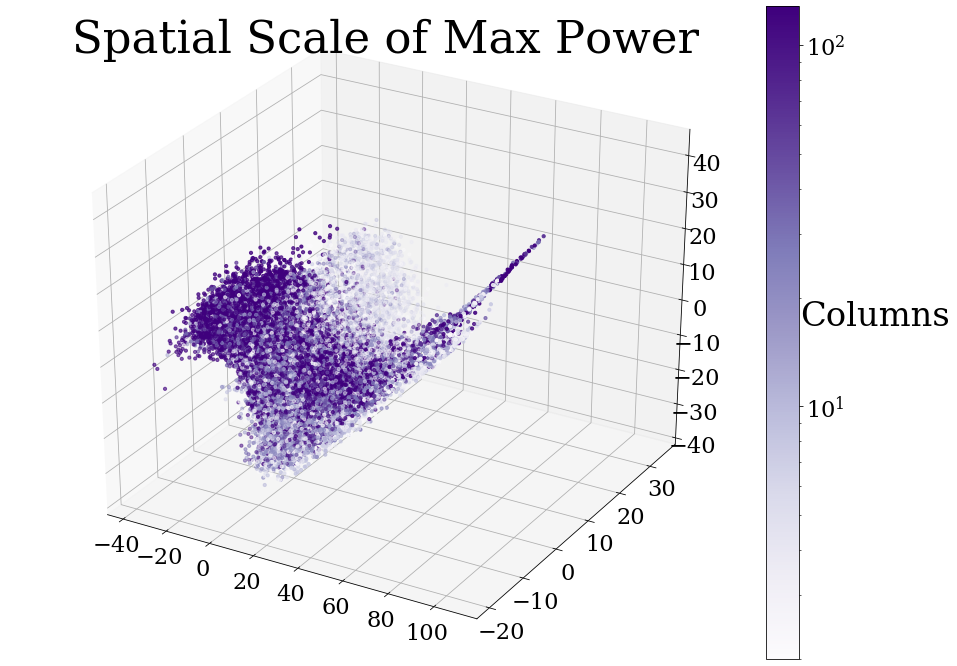

In [9]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=w_spatial_labels, cmap="Purples", s=10.0, norm=matplotlib.colors.LogNorm())
ax.set_title("Spatial Scale of Max Power", fontsize = fz*2.0)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label="Columns", rotation="horizontal", fontsize=fz*1.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], w_spatial_labels)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], w_spatial_labels)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], w_spatial_labels)[0])

## $W_{ 500}$ Absolute

In [ ]:
#-12
W_500_Label_All = np.nanmean(np.abs(np.squeeze(Test_Images[:,-12,:])), axis=1)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=W_500_Label_All, cmap="Purples", s=10.0)
ax.set_title("Mean Absolute Vertical Velocity at "+r"$w_{500}$", fontsize = fz*2.0)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label=r"$ms^{-1}$", rotation="horizontal", fontsize=fz*1.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], W_500_Label_All)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], W_500_Label_All)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], W_500_Label_All)[0])

In [ ]:
quintiles = np.percentile(W_500_Label_All, [20,40,60,80])
out = np.searchsorted(quintiles, W_500_Label_All)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("W 500 Labeling for All", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## $W_{ 500}$

In [ ]:
W_500_Label_All_Real = np.nanmean(np.squeeze(Test_Images[:,-12,:]), axis=1)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=W_500_Label_All_Real, cmap="Purples", s=10.0)
ax.set_title("W 500 Labeling for All", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
#cbar = fig.colorbar(cp)
cbar.set_label(label="W 500", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], W_500_Label_All_Real)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], W_500_Label_All_Real)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], W_500_Label_All_Real)[0])

In [ ]:
quintiles = np.percentile(W_500_Label_All_Real, [20,40,60,80])
out = np.searchsorted(quintiles, W_500_Label_All_Real)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("W 500 Real Labeling for All", fontsize = fz*0.75)

#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## $W_{890}$ ; Top of PBL Absolute

In [ ]:
#-6
W_PBL_Label_All = np.nanmean(np.abs(np.squeeze(Test_Images[:,-6,:])), axis=1)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=W_PBL_Label_All, cmap="Purples", s=10.0)
ax.set_title("W PBl Labeling for All", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="W 500", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], W_PBL_Label_All)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], W_PBL_Label_All)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], W_PBL_Label_All)[0])

## $W_{890}$ ; Top of PBL

In [ ]:
#-6
W_PBL_Label_All_Real = np.nanmean(np.squeeze(Test_Images[:,-6,:]), axis=1)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=W_PBL_Label_All_Real, cmap="Purples", s=10.0)
ax.set_title("W PBl Labeling for All", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="W 500", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], W_PBL_Label_All_Real)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], W_PBL_Label_All_Real)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], W_PBL_Label_All_Real)[0])

In [ ]:
quintiles = np.percentile(W_PBL_Label_All_Real, [20,40,60,80])
out = np.searchsorted(quintiles, W_PBL_Label_All_Real)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("W PBL Real Labeling for All", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## $ W^{'} W^{'}$ ; Entire Test Dataset

In [ ]:
W_Prime_All = np.empty(shape=(len(Test_Images)))

In [ ]:
All_Mean = np.nanmean(Test_Images, axis=0)
for i in range(len(Test_Images)):
    W_Prime_All[i] = np.nanmean(np.square(np.squeeze(Test_Images[i,:,:])-All_Mean))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=W_Prime_All, cmap="Purples", s=10.0)
ax.set_title("W Prime W Prime statistic for All", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="W prime - W prime", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], W_Prime_All)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], W_Prime_All)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], W_Prime_All)[0])

In [ ]:
quintiles = np.percentile(W_Prime_All, [20,40,60,80])
out = np.searchsorted(quintiles, W_Prime_All)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("W Prime W Prime All", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## $ W^{'} W^{'}$ ; Smaller Subset

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html

In [ ]:
W_Prime_All_Subset = np.empty(shape=(len(Test_Images)))

In [ ]:
tree = KDTree(z_test_tsne_track)
for i in range(len(Test_Images)):
    dist, ind = tree.query(z_test_tsne_track[i,:].reshape(1,-1), k=50) 
    temp_mean = np.nanmean(Test_Images[ind,:,:], axis=0)
    W_Prime_All_Subset[i] = np.nanmean(np.square(np.squeeze(Test_Images[i,:,:])-temp_mean))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=W_Prime_All_Subset, cmap="Purples", s=10.0)
ax.set_title("W Prime W Prime statistic for All", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="W prime - W prime", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], W_Prime_All_Subset)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], W_Prime_All_Subset)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], W_Prime_All_Subset)[0])

In [ ]:
quintiles = np.percentile(W_Prime_All_Subset, [20,40,60,80])
out = np.searchsorted(quintiles,W_Prime_All_Subset)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("W Prime W Prime Subset", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

# External Metrics

In [ ]:
path = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-19-4*'
real_ds = xr.open_mfdataset(path)
#precip rate
P_CRM = real_ds.CRM_PREC_LON_0e_to_360e_LAT_20s_to_20n
#column water vapor, column saturation fraction
Q_CRM = real_ds.CRM_QV_LON_0e_to_360e_LAT_20s_to_20n
#DSE, lower tropospheric stability
T_CRM = real_ds.CRM_T_LON_0e_to_360e_LAT_20s_to_20n
#latitude 
latitudes = real_ds.LAT_20s_to_20n

#gms
U_GCM = real_ds.U10_LON_0e_to_360e_LAT_20s_to_20n
V_GCM = real_ds.VAP_LON_0e_to_360e_LAT_20s_to_20n
T_GCM = real_ds.T_LON_0e_to_360e_LAT_20s_to_20n
Q_GCM = real_ds.QAP_LON_0e_to_360e_LAT_20s_to_20n

latitudes = xr.DataArray.squeeze(latitudes).values
P_CRM = xr.DataArray.squeeze(P_CRM).values
Q_CRM = xr.DataArray.squeeze(Q_CRM).values
T_CRM = xr.DataArray.squeeze(T_CRM).values

U_GCM = xr.DataArray.squeeze(U_GCM).values
V_GCM = xr.DataArray.squeeze(V_GCM).values
T_GCM = xr.DataArray.squeeze(T_GCM).values
Q_GCM = xr.DataArray.squeeze(Q_GCM).values

path = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h0.2008-11.nc'
next_ds = xr.open_dataset(path)

#land fraction
land_frac = next_ds.LANDFRAC
land_frac = xr.DataArray.squeeze(land_frac).values

## Land Fraction

In [ ]:
trop_land = land_frac[37:59, :]
geo_labels = np.zeros(shape=(int(len(z_test_tsne_track)/(22*144)), 22, 144))
geo_labels[:,:,:] = np.nan

for i in range(len(geo_labels)):
    geo_labels[i,:,:] = trop_land[:,:]
    
geo_label_final = np.reshape(geo_labels, (geo_labels.size))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=geo_label_final, cmap="winter", s=10.0)
ax.set_title("Land Fraction", fontsize = fz*2)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label="Land Frac.", rotation="horizontal", fontsize=fz, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], geo_label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], geo_label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], geo_label_final)[0])

In [ ]:
quintiles = np.percentile(geo_label_final, [20,40,60,80])
out = np.searchsorted(quintiles,geo_label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("Land Fraction", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## Latitude

In [ ]:
lat_labels = np.zeros(shape=(int(len(z_test_tsne_track)/(22*144)), 22, 144))
lat_labels[:,:,:] = np.nan

temp_lats = np.abs(latitudes)
scaled_lats = np.interp(temp_lats, (np.min(temp_lats), np.max(temp_lats)), (0, +1))

for i in range(len(lat_labels)):
    for j in range(len(lat_labels[0][0])):
        lat_labels[i,:,j] = scaled_lats
        
lat_label_final = np.reshape(lat_labels, (lat_labels.size))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=lat_label_final, cmap="Purples", s=10.0)
ax.set_title("Latitude Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Distance From Equator", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], lat_label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], lat_label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], lat_label_final)[0])

In [ ]:
quintiles = np.percentile(lat_label_final, [20,40,60,80])
out = np.searchsorted(quintiles,lat_label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("Latitude Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## Precipitation Rate

In [ ]:
P_CRM_Fixed = P_CRM*60*60*24
P_CRM_Label = np.nansum(P_CRM_Fixed, axis = 1)
P_CRM_Label_final = np.reshape(P_CRM_Label, (P_CRM_Label.size))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=P_CRM_Label_final, cmap="Greens", s=10.0)
ax.set_title("Precipitation Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Precip. Rate", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], P_CRM_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], P_CRM_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], P_CRM_Label_final)[0])

In [ ]:
quintiles = np.percentile(P_CRM_Label_final, [20,40,60,80])
out = np.searchsorted(quintiles,P_CRM_Label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("Precipitation Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

In [ ]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
plev = np.array(others.variables['lev'])
ps = np.array(others.variables['PS'])
g = 9.81 #m/s^2
hyai = np.array(others.variables['hyai'])
hybi = np.array(others.variables['hybi'])
#print(hyai.shape)
#print(hyai)
cp = 1004.0
L = 2256000.0
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
dp = P[1:]-P[:-1] # Differential pressure [Pa]
Scalar_Q_CRM = np.nansum(np.nansum(Q_CRM*dp[None, :, None, None, None]*L/g, axis=1),axis=1)
Scalar_T_CRM = np.nansum(np.nansum(T_CRM*dp[None, :, None, None, None]*cp/g, axis=1), axis=1)
Q_CRM_Label_final = np.reshape(Scalar_Q_CRM, (Scalar_Q_CRM.size))
T_CRM_Label_final = np.reshape(Scalar_T_CRM, (Scalar_T_CRM.size))

## Column Dry Static Energy

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=T_CRM_Label_final, cmap="Purples", s=10.0)
ax.set_title("Column DSE Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="W/m^2", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], T_CRM_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], T_CRM_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], T_CRM_Label_final)[0])

In [ ]:
quintiles = np.percentile(T_CRM_Label_final, [20,40,60,80])
out = np.searchsorted(quintiles,T_CRM_Label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("Column DSE Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## Column Water Vapor

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=Q_CRM_Label_final, cmap="Purples", s=10.0)
ax.set_title("Column MSE Labeling", fontsize = fz*2.0)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp, pad=0.02)
cbar.set_label(label=r"$wm^{-2}$", rotation="horizontal", fontsize=fz, labelpad=30, y = 0.50)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], Q_CRM_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], Q_CRM_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], Q_CRM_Label_final)[0])

In [ ]:
quintiles = np.percentile(Q_CRM_Label_final, [20,40,60,80])
out = np.searchsorted(quintiles,Q_CRM_Label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("Column Vapor Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## Lower Tropospheric Stability

In [ ]:
T_Top = np.squeeze(T_CRM[:,-10,:,:,:])
T_Top_Theta = T_Top*(691.0/1013.25)**(287.0/1004.0)

T_Bottom = np.squeeze(T_CRM[:,-1,:,:,:])
LTS = T_Top_Theta - T_Bottom
LTS = np.nansum(LTS, axis=1)
LTS_Label_final = np.reshape(LTS, (LTS.size))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=LTS_Label_final, cmap="Purples", s=10.0)
ax.set_title("Lower Tropospheric Stability Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="LTS", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], LTS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], LTS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], LTS_Label_final)[0])

In [ ]:
quintiles = np.percentile(LTS_Label_final, [20,40,60,80])
out = np.searchsorted(quintiles,LTS_Label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("LTS Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## Column Saturation Fraction

http://cms.ncas.ac.uk/documents/vn4.5/p029.pdf

In [ ]:
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))



def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    #p = np.moveaxis((hyam*P0+hybm*PS),0,1) # Total pressure (Pa)
    p = hyam*P0+hybm*PS
    return R*esat(T)*RH/(Rv*p[None,:-1,None,None])

In [ ]:
GCM_Q = real_ds.Q_LON_0e_to_360e_LAT_20s_to_20n.values
GCM_T = real_ds.T_LON_0e_to_360e_LAT_20s_to_20n.values
CSF_Top = np.nansum(GCM_Q*dp[None,:,None,None]/g, axis=1)

Q_sat = qv(GCM_T,1.0,P0,PS,hyai,hybi)
CSF_bottom = np.nansum(Q_sat*dp[None,:,None,None]/g, axis=1)
CSF = (CSF_Top/CSF_bottom)
CSF_Label_final = np.reshape(CSF, (CSF.size))

In [ ]:
scipy.stats.describe(CSF_Label_final)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=CSF_Label_final, cmap="Greens", s=10.0)
ax.set_title("Column Saturation Fraction Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="CSF", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], CSF_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], CSF_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], CSF_Label_final)[0])

In [ ]:
quintiles = np.percentile(CSF_Label_final, [20,40,60,80])
out = np.searchsorted(quintiles,CSF_Label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("CSF Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## Bowen Ratio

In [ ]:
SH = real_ds.SHFLX_LON_0e_to_360e_LAT_20s_to_20n.values
LH = real_ds.LHFLX_LON_0e_to_360e_LAT_20s_to_20n.values

Bowen = SH/LH
Bowen_Label_final = np.reshape(Bowen, (Bowen.size))
Bowen_Label_final = np.nan_to_num(Bowen_Label_final, posinf=6.0, neginf=0.0)
scipy.stats.describe(Bowen_Label_final) 
#masked_Y = np.ma.array(Bowen_Label_final, mask=~np.isfinite(Bowen))
#print(np.nanmin(masked_Y))
#print(np.nanmax(masked_Y))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=Bowen_Label_final, cmap="Greens", s=10.0)
ax.set_title("Bowen Ratio Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Bowen Ratio", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], Bowen_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], Bowen_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], Bowen_Label_final)[0])

In [ ]:
quintiles = np.percentile(Bowen_Label_final, [20,40,60,80])
out = np.searchsorted(quintiles,Bowen_Label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("BR Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## Surface Fluxes

In [ ]:
#downwelling longwave flux at the surface
FLDS = real_ds.FLDS_LON_0e_to_360e_LAT_20s_to_20n.values
#net longwave flux at the surface
FLNS = real_ds.FLNS_LON_0e_to_360e_LAT_20s_to_20n.values
#downwelling solar flux at surface
FSDS = real_ds.FSDS_LON_0e_to_360e_LAT_20s_to_20n.values
#net solar flux at the surface
FSNS = real_ds.FSNS_LON_0e_to_360e_LAT_20s_to_20n.values

FLDS_Label_final = np.reshape(FLDS, (FLDS.size))
FLNS_Label_final = np.reshape(FLNS, (FLNS.size))
FSDS_Label_final = np.reshape(FSDS, (FSDS.size))
FSNS_Label_final = np.reshape(FSNS, (FSNS.size))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=FLDS_Label_final, cmap="Greens", s=10.0)
ax.set_title('Downwelling longwave flux at surface', fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="FLDS", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], FLDS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], FLDS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], FLDS_Label_final)[0])

In [ ]:
quintiles = np.percentile(FLDS_Label_final, [20,40,60,80])
out = np.searchsorted(quintiles,FLDS_Label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("FLDS Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=FLNS_Label_final, cmap="Purples", s=10.0)
ax.set_title("Net Longwave Flux at sfc", fontsize = fz*2.0)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label=r"$wm^{-2}$", rotation="horizontal", fontsize=fz, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], FLNS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], FLNS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], FLNS_Label_final)[0])

In [ ]:
quintiles = np.percentile(FLNS_Label_final, [20,40,60,80])
out = np.searchsorted(quintiles,FLNS_Label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("FLNS Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=FSDS_Label_final, cmap="Greens", s=10.0)
ax.set_title("Downwelling solar flux at sfc.", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="FSDS", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], FSDS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], FSDS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], FSDS_Label_final)[0])

In [ ]:
quintiles = np.percentile(FSDS_Label_final, [20,40,60,80])
out = np.searchsorted(quintiles,FSDS_Label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("FSDS Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=FSNS_Label_final, cmap="Greens", s=10.0)
ax.set_title("Net Solar flux at sfc.", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="FSNS", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], FSNS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], FSNS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], FSNS_Label_final)[0])

In [ ]:
quintiles = np.percentile(FSDS_Label_final, [20,40,60,80])
out = np.searchsorted(quintiles,FSDS_Label_final)

In [ ]:
cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("FSDS Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

# Bouyancy Formula

http://www.atmo.arizona.edu/students/courselinks/spring11/hwr523/HWR423_523_files/Module1b.pdf

In [ ]:
#Boundary Layer -> 1000-850 hpa
#Lower Free Troposphere -> 850-500 hpa 

def theta_e_calc(press_hPa, temp, q):
    pref = 100000.
    tmelt  = 273.15
    CPD = 1005.7
    CPV=1870.0
    CPVMCL=2320.0
    RV=461.5
    RD=287.04
    EPS=RD/RV
    ALV0=2.501E6
    #press, tempc,theta_e
    #cdef double r,ev_hPa, TL, chi_e
    press = press_hPa * 100. # in Pa
    tempc = temp - tmelt # in C
    r = q / (1. - q)
    # get ev in hPa 
    ev_hPa = press_hPa * r / (EPS + r)
    #get TL
    TL = (2840. / ((3.5*np.log(temp)) - (np.log(ev_hPa)) - 4.805)) + 55.
    #calc chi_e:
    chi_e = 0.2854 * (1. - (0.28*r))
    theta_e = temp * (pref / press)**chi_e * np.exp(((3.376/TL) - 0.00254) * r * 1000. * (1. + (0.81 * r)))
    return theta_e



def theta_e_sat_calc(press_hPa, temp):
    pref = 100000.
    tmelt  = 273.15
    CPD = 1005.7
    CPV=1870.0
    CPVMCL=2320.0
    RV=461.5
    RD=287.04
    EPS=RD/RV
    ALV0=2.501E6
    #press, tempc,theta_e
    #cdef double r,ev_hPa, TL, chi_e
    press = press_hPa * 100. # in Pa
    tempc = temp - tmelt # in C
    
    e_sat = 611.0*np.exp((17.3*tempc)/(tempc+273.15))
    q = 0.622*e_sat/(press-(1-0.622)*e_sat)
    
    r = q / (1. - q)
    # get ev in hPa 
    ev_hPa = press_hPa * r / (EPS + r)
    #get TL
    TL = (2840. / ((3.5*np.log(temp)) - (np.log(ev_hPa)) - 4.805)) + 55.
    #calc chi_e:
    chi_e = 0.2854 * (1. - (0.28*r))
    theta_e = temp * (pref / press)**chi_e * np.exp(((3.376/TL) - 0.00254) * r * 1000. * (1. + (0.81 * r)))
    return theta_e

w_b = 0.52
w_l = 0.48

## Part A

In [ ]:
Theta_e = np.empty(GCM_Q.shape)
Theta_e_s = np.empty(GCM_Q.shape)
for i in range(len(GCM_Q)):
    for j in range(len(GCM_Q[i])):
        for k in range(len(GCM_Q[i][j])):
            for l in range(len(GCM_Q[i][j][k])):
                Theta_e[i,j,k,l] = theta_e_calc(levs[j], GCM_T[i,j,k,l], GCM_Q[i,j,k,l])
                Theta_e_s[i,j,k,l] = theta_e_sat_calc(levs[j], GCM_T[i,j,k,l])

In [ ]:


theta_e_BL = np.nanmean(Theta_e[:,-7:,:,:], axis= 1)
theta_e_s_BL = np.nanmean(Theta_e_s[:,-7:,:,:], axis= 1)

theta_e_LFT = np.nanmean(Theta_e[:,-12:-6,:,:], axis= 1)
theta_e_s_LFT = np.nanmean(Theta_e_s[:,-12:-6,:,:], axis= 1)


part_a = (theta_e_BL - theta_e_s_LFT)/theta_e_s_LFT
part_a_final = np.reshape(part_a, (part_a.size))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=part_a_final, cmap="Greens", s=10.0)
ax.set_title("Part A", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Part A", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], part_a_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], part_a_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], part_a_final)[0])

In [ ]:
quintiles = np.percentile(part_a_final, [20,40,60,80])
out = np.searchsorted(quintiles,part_a_final)

cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("Buoyancy Part A Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## Part B

In [ ]:
part_b = (theta_e_s_LFT - theta_e_LFT)/theta_e_s_LFT
part_b_final = np.reshape(part_b, (part_b.size))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=part_b_final, cmap="Greens", s=10.0)
ax.set_title("Part B", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Part B", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], part_b_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], part_b_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], part_b_final)[0])

In [ ]:
quintiles = np.percentile(part_b_final, [20,40,60,80])
out = np.searchsorted(quintiles,part_b_final)

cmap = matplotlib.colors.ListedColormap(["pink", "green", "blue","red","black"])
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=out, cmap=cmap, s=10.0)
ax.set_title("Buoyancy Part B Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Percentiles", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)
cbar.set_ticks([0,1,2,3,4])
cbar.set_ticklabels(["0","20","40","60","80"])

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], out)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], out)[0])

## All

In [ ]:
total = 9.81*(w_b*part_a_final+w_l*part_b_final)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=total, cmap="Greens", s=10.0)
ax.set_title("Buoyancy", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="Buoyancy", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], total)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], total)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], total)[0])

## Gross Moist Stability

In [ ]:
NNQBP = real_ds.QBP_LON_0e_to_360e_LAT_20s_to_20n.values
NNTBP = real_ds.TBP_LON_0e_to_360e_LAT_20s_to_20n.values
# Ideal gas law -> rho=p(R_d*T_v)
eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
R_D = 287 # Specific gas constant of dry air in J/K/kg
Z_final = np.empty(NNTBP.shape)
levs = real_ds.lev.values
for i in range(len(Z_final)):
    for j in range(len(Z_final[0][0])):
        for k in range(len(Z_final[0][0][0])):
            r = NNQBP[i,:,j,k]/(NNQBP[i,:,j,k]**0-NNQBP[i,:,j,k])
            Tv = NNTBP[i,:,j,k]*(r**0+r/eps)/(r**0+r)
            RHO = 1e2*levs/(R_D*Tv)
            Z = scipy.integrate.cumtrapz(x=1e2*levs,y=1/(g*RHO))
            Z = np.concatenate((np.zeros(1,),Z))
            Z = np.flip(Z)
            Z_final[i,:,j,k] = Z


In [ ]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-20-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
lats = np.squeeze(extra_variables.LAT_20s_to_20n.values)
lons = np.squeeze(extra_variables.LON_0e_to_360e.values)

In [ ]:
print(lats)

In [ ]:
GCM_U = real_ds.U10_LON_0e_to_360e_LAT_20s_to_20n.values
GCM_V = real_ds.VAP_LON_0e_to_360e_LAT_20s_to_20n.values

cp = 1004.0
L = 2256000.0
dse = GCM_T*cp + g*Z_final
bottom = np.nansum(dse*GCM_V*dp[None,:,None,None]/g, axis=1)
mse = dse + GCM_Q*L
top = np.nansum(mse*GCM_V*dp[None,:,None,None]/g, axis=1)



In [ ]:
def GMS_field(GMS_T, GMS_B, y, x):
    r=6.371e6
    GMS = np.zeros(shape=(len(GMS_T),len(y)-2,len(x)-2))
    GMS[:,:,:] = np.nan
    count_x = 0
    count_y = 0
    for a in range(len(GMS_T)):
        for i in range(len(x)):
            if i !=0 and i != len(x)-1:
                for j in range(len(y)):
                    if j !=0 and j != len(y)-1:
                    
                        dy = math.radians(y[j+1]-[y[j-1]])
                
                        y_comp_top = (1/(r*math.cos(math.radians(y[j]))))*(GMS_T[a,j+1,i]-GMS_T[a,j-1,i])/dy
                        y_comp_bottom = (1/(r*math.cos(math.radians(y[j]))))*(GMS_B[a,j+1,i]-GMS_B[a,j-1,i])/dy
                        
                    
                        GMS[a,count_y,count_x] =y_comp_top/y_comp_bottom
                        count_y = count_y+1
                    
                count_x = count_x+1
            count_y = 0
        count_x=0
                
    
    
    
    return GMS

GMS = GMS_field(top, bottom, lats, lons)

In [ ]:
GMS_z = np.empty(shape=(2,16,22,144))

count = 0
for i in range(16):
    for j in range(22):
        for k in range(144):
            GMS_z[:,i,j,k] = z_test_tsne_track[count,:] 
            count = count+1
        
GMS_z_final = GMS_z[:,:,1:-1,1:-1]

GMS_z_plot = np.empty(shape=(len(GMS_z_final[0])*len(GMS_z_final[0][0])*len(GMS_z_final[0][0][0]),2))
count = 0
for i in range(16):
    for j in range(20):
        for k in range(142):
            GMS_z_plot[count,:] = GMS_z_final[:,i,j,k]
            count = count+1
            
            
            
GMS_Label_final = np.reshape(GMS, (GMS.size))

In [ ]:
scipy.stats.describe(GMS_Label_final)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=GMS_Label_final, cmap="Greens", s=10.0)
ax.set_title("Gross Moist Stability Labeling", fontsize = fz*0.75)
#ax.set_xlim(-40,100)
#ax.set_ylim(-20,35)
cbar = fig.colorbar(cp)
cbar.set_label(label="GMS", rotation="horizontal", fontsize=fz*0.5, labelpad=30, y = 0.55)

print(scipy.stats.pearsonr(z_test_tsne_track[:, 0], GMS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 1], GMS_Label_final)[0])
print(scipy.stats.pearsonr(z_test_tsne_track[:, 2], GMS_Label_final)[0])